## Fit and Tune a Random Forest Model
Create and fit a Random Forest model on the "Diff Data" fromm the 2015-18 World Series.  Tune hyperparameters using Grid Search CV.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
#Import Data - USA's differential data
df = pd.read_csv('../data/output/new_features_diffdata.csv')
df.head()

,Opp,Tournament,Poss_Time_Diff,Score_Diff,Conv_Diff,Tries_Diff,Passes_Diff,Contestable_KO_Win_pct_Diff,PenFK_Against_Diff,RuckMaul_Diff,...,-99 : -75,-74 : -25,-24 : -1,0 : 25,26 : 50,51 : 75,76 : 100,101 : 125,126 : 150,Result
0,AUSTRALIA,2015_Cape_Town,13.966480,-10.638298,-14.285714,0.250000,25.925926,-50.000000,0.000000,0.000000,...,0.0,-12.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,WALES,2015_Cape_Town,7.471264,15.555556,14.285714,0.083333,27.868852,25.000000,-20.000000,-100.000000,...,0.0,0.0,0.0,12.5,0.0,0.0,0.0,0.0,0.0,1
2,KENYA,2015_Cape_Town,-33.136095,-44.444444,-33.333333,-0.750000,-10.638298,-16.666667,66.666667,60.000000,...,0.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,NEW ZEALAND,2015_Cape_Town,51.758794,33.333333,33.333333,0.000000,76.119403,-75.000000,-50.000000,-100.000000,...,-37.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,FIJI,2015_Cape_Town,12.880562,-20.833333,-25.000000,0.266667,38.461538,-66.666667,-33.333333,-33.333333,...,0.0,-12.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Randomize Data

In [3]:
#Shuffle dataframes before running model to prevent overfitting
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
#Diagnostic
# df.info()
list(df.columns)

### Pre-processing data

In [5]:
#Create a list of features to drop that are unneccessary or will bias the prediction
droplist = ['Opp', 'Score_Diff', 'Tries_Diff','Tournament', 'Conv_Diff','-175 : -150', '-149 : -125','-124 : -100', '-99 : -75', '-74 : -25','-24 : -1','0 : 25','26 : 50','51 : 75','76 : 100','101 : 125','126 : 150']

rf_data = df.drop((droplist), axis=1)

#Drop rows with Result == "2" (Ties). This label messes up classification models
rf_data.drop(rf_data[rf_data.Result == 2].index, inplace=True)

In [8]:
#Pull out the variable we're trying to predict: 'Result'
X = rf_data.drop('Result',axis=1)
y = rf_data['Result']
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30)

### Train/Test Split
Scale before train/test split

In [9]:
#Split into train/test/validate sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

### Scale the data
Using sklearn StandardScaler

In [33]:
# Standardize data (0 mean, 1 stdev)
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print("Scaled training set Parameters \n")

print("Parameters from scaler model")
print(sc.get_params(deep=True))

Scaled training set Parameters 

Parameters from scaler model
{'copy': True, 'with_mean': True, 'with_std': True}


### Build and Fit the RF Model

In [12]:
from sklearn.ensemble import RandomForestClassifier

#Fit RF Classifier model
rf = RandomForestClassifier()

from pprint import pprint
# Look at parameters used by our current forest
print('Default Parameters currently in use:\n')
pprint(rf.get_params())

Default Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### Randomized Search
First, use Randomized Search to narrow down the parameter values.  Then we'll use the smaller range of values in GridSearch.

In [13]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion - gini or entropy?
criterion = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'criterion': criterion}
pprint(random_grid)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [14]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 101)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=101, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

#Get the best parameters
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.9min finished
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 1200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'criterion': 'gini',
 'bootstrap': True}

### Evaluation
Create a function to evaluate model improvement

In [15]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

Evaluate model performance using <code>evaluate()</code> function:

In [34]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 101)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
#Model Performance
#Average Error: 3.9199 degrees.
#Accuracy = 93.36%.
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
#Model Performance
#Average Error: 3.7152 degrees.
#Accuracy = 93.73%.

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.5000 degrees.
Accuracy = -inf%.
Model Performance
Average Error: 0.3696 degrees.
Accuracy = -inf%.
Improvement of nan%.


/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


### Grid Search with Cross Validation
Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define.  

### Hyperparameters
* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

### Parameters from Randomized Search

In [18]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 

param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 50, 60],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [400, 800, 1200],
    'criterion': ['gini']
}
# Create a base model
rf = RandomForestClassifier(random_state = 101)

# execute gridsearch and get best score
rf_grid = GridSearchCV(rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring= 'accuracy')

# fit on ALL grid.fit(X, y) and NOT grid.fit(X_train, y_train) because the GridSearchCV will automatically 
# split the data into training and testing data (this happen internally).
rf_grid.fit(X_train, y_train)

print("RF Grid search Best Score:", rf_grid.best_score_)
#print("RF Grid search Cross Validation Results:", rf_grid.cv_results_)

#print best parameters
print("Best Parameters from Grid Search: \n", rf_grid.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  2.4min finished
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RF Grid search Best Score: 0.6285714285714286
Best Parameters from Grid Search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 800}


## New Model with Best Parameters

In [21]:
# {'bootstrap': True, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 800}
rf1 = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=40, max_features='auto', min_samples_leaf=2, min_samples_split=10, n_estimators=800, random_state=101)
rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

### Predict

In [25]:
from sklearn.metrics import classification_report,confusion_matrix

# get prediction
y_pred = rf1.predict(X)

#Output confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))

print("Classification Report")
print(classification_report(y, y_pred))

#print accuracy score
print("\n")
print("Accuracy Score")
print(rf1.score(X, y))

Confusion Matrix
[[29 37]
 [13 72]]
Classification Report
              precision    recall  f1-score   support

           0       0.69      0.44      0.54        66
           1       0.66      0.85      0.74        85

   micro avg       0.67      0.67      0.67       151
   macro avg       0.68      0.64      0.64       151
weighted avg       0.67      0.67      0.65       151



Accuracy Score
0.6688741721854304


## Next Steps - Predict on New Data
Set up new, unseen data, and predict results.

In [27]:
#Import validation data
valdf = pd.read_csv('../data/output/new_features_diffdata_validate_2018-19.csv')
valdf.head()

,Opp,Tournament,Poss_Time_Diff,Score_Diff,Conv_Diff,Tries_Diff,Passes_Diff,Contestable_KO_Win_pct_Diff,PenFK_Against_Diff,RuckMaul_Diff,...,Lineout_Win_Pct_Diff,Scrum_Win_Pct_Diff,Less than -75,-50 : -75,-25 : -49,24 : -24,25 : 49,50 : 75,More than 75,Result
0,AUSTRALIA,2019_Dubai_7s,-28.601253,29.166667,25.000000,0.266667,-45.714286,-30.000000,33.333333,-100.000000,...,1.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,1
1,Argentina,2019_Cape_Town,21.813031,22.222222,33.333333,-0.750000,28.358209,-25.000000,14.285714,100.000000,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,1
2,CANADA,2019_Sydney_7s,16.037736,44.000000,50.000000,-0.500000,19.354839,-41.666667,20.000000,100.000000,...,1.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,1
3,ENGLAND,2019_Hamilton_7s,-27.884615,46.153846,50.000000,-0.333333,-41.333333,33.333333,-33.333333,-100.000000,...,1.0,-1.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,1
4,ENGLAND,2019_Sydney_7s,14.127424,46.153846,50.000000,-0.333333,55.555556,0.000000,-50.000000,33.333333,...,1.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,1


In [ ]:
valdf.columns

In [28]:
#Drop features that are unneccessary/str or will bias the prediction
#Create a list of features to drop that are unneccessary or will bias the prediction
droplist = ['Opp', 'Score_Diff', 'Tries_Diff','Tournament', 'Conv_Diff','Less than -75', '-50 : -75', '-25 : -49', '24 : -24', '25 : 49',
       '50 : 75', 'More than 75']
val_data = valdf.drop((droplist), axis=1)

#Drop rows with Result == "T" (Ties). This label messes up classification models
val_data.drop(val_data[val_data.Result == 2].index, inplace=True)

#Pull out the variable we're trying to predict: 'Result'
val_X = val_data.drop('Result',axis=1)
val_y = val_data['Result']

### Scale New Data

In [29]:
# Standardize data (0 mean, 1 stdev)
# Scaler parameters used in scaling Training data
# Parameters from scaler model
#{'copy': True, 'with_mean': True, 'with_std': True}
from sklearn.preprocessing import StandardScaler

scale = StandardScaler(copy=True, with_mean=True, with_std=True)
scaled_val_X = scale.fit_transform(val_X)
#X_test = sc.transform(X_test)

print("Scaled training set Parameters \n")
#print("(Use later for scaling unseen production data)")
#print(X_train.get_params(deep=True))

print("Parameters from scaler model")
print(scale.get_params(deep=True))

Scaled training set Parameters 

Parameters from scaler model
{'copy': True, 'with_mean': True, 'with_std': True}


/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [30]:
#from sklearn.metrics import classification_report,confusion_matrix

# get prediction
val_y_pred = rf1.predict(scaled_val_X)

#Output confusion matrix
print("Confusion Matrix")
print(confusion_matrix(val_y, val_y_pred))

print("Classification Report")
print(classification_report(val_y, val_y_pred))

#print accuracy score
print("\n")
print("Accuracy Score")
print(rf1.score(X, y))

Confusion Matrix
[[ 5  2]
 [ 5 11]]
Classification Report
              precision    recall  f1-score   support

           0       0.50      0.71      0.59         7
           1       0.85      0.69      0.76        16

   micro avg       0.70      0.70      0.70        23
   macro avg       0.67      0.70      0.67        23
weighted avg       0.74      0.70      0.71        23



Accuracy Score
0.6688741721854304


In [31]:
#Find Feature Importances
impt = rf1.feature_importances_
feature_importances = pd.DataFrame(impt,
                                   index = val_X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print("Feature Importance")
print(feature_importances)

Feature Importance
                             importance
Contestable_KO_Win_pct_Diff    0.206223
Poss_Time_Diff                 0.185208
Passes_Diff                    0.143457
Ruck_Win_pct_Diff              0.101312
PenFK_Against_Diff             0.095072
Scrum_Win_Pct_Diff             0.091571
Lineout_Win_Pct_Diff           0.078781
RuckMaul_Diff                  0.059250
Cards_diff                     0.039125


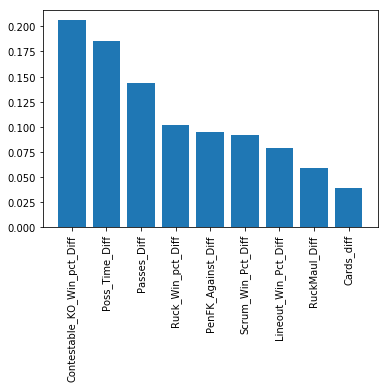

In [39]:
# Plot feature importance
#plt.bar(range(len(rfc.feature_importances_)), rfc.feature_importances_)
plt.xticks(rotation='vertical')
plt.bar(feature_importances.index, feature_importances.importance)
plt.show()